# Imports
With inline backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
% denotes magic line in IPython

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
# Disable unnecessary warnings, remember to return the old_v
# after using.
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

# Configuration of Neural Network

In [2]:
# Convolutional layer 1.
filter_size1 = 5
num_filters1 = 16

# Convolutional layer 2.
filter_size2 = 5
num_filters2 = 36

# Fully-connected layer.
fc_size = 128

# Load Data
The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path. ('data/MNIST')

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
print('type(data.train.labels): ', type(data.train.labels))
print('type(data.train.images): ', type(data.train.images))
print('data.train.labels.shape: ', data.train.labels.shape)
print('data.train.images.shape: ', data.train.images.shape)
print('Five first train labels: \n', data.train.labels[0:5, :])
print('Five first train images: \n', data.train.images[0:5, :])
print('data.train.labels[0]: \n', data.train.labels[0])
print('data.train.labels[0].shape: ', data.train.labels[0].shape)
print('data.train.images[0].shape: ', data.train.images[0].shape)

type(data.train.labels):  <class 'numpy.ndarray'>
type(data.train.images):  <class 'numpy.ndarray'>
data.train.labels.shape:  (55000, 10)
data.train.images.shape:  (55000, 784)
Five first train labels: 
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Five first train images: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
data.train.labels[0]: 
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
data.train.labels[0].shape:  (10,)
data.train.images[0].shape:  (784,)


The class-labels (data.test.labels) are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element.
We need the class-numbers as integers (data.test.cls) for the test-set, so we calculate it:

In [6]:
data.train.cls = np.argmax(data.train.labels, axis=1)
data.test.cls = np.argmax(data.test.labels, axis=1)
print('data.train.labels[0:3, :]: \n', data.train.labels[0:3, :])
print('data.train.cls: ', data.train.cls)
print('data.test.labels[0:3, :]: \n', data.test.labels[0:3, :])
print('data.test.cls: ', data.test.cls)
print('type(data.test.cls): ', type(data.test.cls))

data.train.labels[0:3, :]: 
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
data.train.cls:  [7 3 4 ... 5 6 8]
data.test.labels[0:3, :]: 
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
data.test.cls:  [7 2 1 ... 4 5 6]
type(data.test.cls):  <class 'numpy.ndarray'>


# Data Dimensions
The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below

In [7]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Helper-function for plotting images
Function used to plot 9 images in a 3*3 grid, and writing the true and predicted classes below each image.

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3*3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Plot a few images to see if data is correct

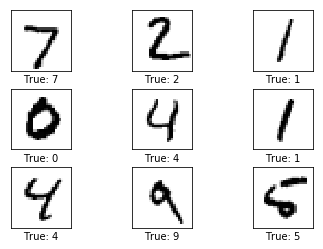

In [9]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Tensorflow graph

## Helper-functions for creating new variables

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Helper function for creating a new Convolutional Layer

In [12]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
    
    # Shape of the filter-weights for the convolution.
    # This format is determined by the Tensorflow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
    
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    # Create the Tensorflow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2*2 max-pooling, which means that we
        # consider 2*2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
    
    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) = max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.
    
    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

## Helper-function for flattening a layer
A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [14]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    
    # The number of features is: img_height * img_width * num_channels
    # We can use a function from Tensorflow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]
    
    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
    

## Helper-function for creating a new Fully-Connected Layer

In [15]:
def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
    
    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases
    
    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## Placeholder variables

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [18]:
x

<tf.Tensor 'x_1:0' shape=(?, 784) dtype=float32>

In [19]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [20]:
x_image

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

In [18]:
y_true_cls = tf.argmax(y_true, dimension=1)

## Convolutional layer 1

In [19]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                  num_input_channels=num_channels,
                  filter_size=filter_size1,
                  num_filters=num_filters1,
                  use_pooling=True)

In [20]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

## Convolutional layer 2

In [21]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                  num_input_channels=num_filters1,
                  filter_size=filter_size2,
                  num_filters=num_filters2,
                  use_pooling=True)

In [22]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

## Flatten layer

In [23]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [24]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

## Fully-Connected Layer 1

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [26]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

## Fully-Connected Layer 2

In [27]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [28]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

## Predicted Class

In [29]:
y_pred = tf.nn.softmax(layer_fc2)

In [30]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost-function to be optimized
A `Tensor` of the same shape as `labels` and of the same type as `logits`.  

The function tf.nn.softmax_cross_entropy_with_logits calculates the cost value for each batch's element.

In [31]:
cross_entropy = \
tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                        labels=y_true)

If `axis` is None, all dimensions are reduced, and a
tensor with a single element is returned by tf.reduce_mean.  

cost is cost value for a batch.

In [32]:
cost = tf.reduce_mean(cross_entropy)
print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


## Optimization Method

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
print(type(optimizer))
print(optimizer)

<class 'tensorflow.python.framework.ops.Operation'>
name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_Variable/ApplyAdam"
input: "^Adam_1/update_Variable_1/ApplyAdam"
input: "^Adam_1/update_Variable_2/ApplyAdam"
input: "^Adam_1/update_Variable_3/ApplyAdam"
input: "^Adam_1/update_Variable_4/ApplyAdam"
input: "^Adam_1/update_Variable_5/ApplyAdam"
input: "^Adam_1/update_Variable_6/ApplyAdam"
input: "^Adam_1/update_Variable_7/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"



## Performance Measures
We need a few more performance measures to display the progress to the user. This is a vector of booleans whether the predicted class equals the true class of each image.

In [35]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [37]:
session = tf.Session()

## Initialize variables
The variables for weights and biases must be initialized before we start optimizing them.

In [38]:
session.run(tf.initialize_all_variables())

Some codes to display cost value information.  

Run optimizer will return None because it is a tf.Operation.

In [39]:
# x_batch, y_true_batch = data.train.images[0:50, :], data.train.labels[0:50, :]
# feed_dict_train = {x: x_batch,
#                     y_true: y_true_batch}
# cross_entropy_value = session.run(cross_entropy, feed_dict=feed_dict_train)
# cost_value = session.run(cost, feed_dict=feed_dict_train)
# optimizer_value = session.run(optimizer, feed_dict=feed_dict_train)
# print(cross_entropy_value.shape)
# print(cross_entropy_value)
# print(cost_value)
# print(optimizer_value)

## Helper-function to perform optimization interations
There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model (cost function) using all these images. We therefore only use a small batch of images in each iteration of the optimizer.  
If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [40]:
train_batch_size = 64

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [41]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy
    global total_iterations
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for i in range(total_iterations,
                  total_iterations + num_iterations):
        
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assgins the variables in feed dict train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy {1:>6.1%}"
            
            # Print it.
            print(msg.format(i + 1, acc))
            
    # Update the total number of iterations performed.
    total_iterations += num_iterations
    
    # Ending time.
    end_time = time.time()
    
    # Difference between start and end-times.
    time_dif = end_time - start_time
    
    # Print the time-usage
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-function to plot example errors
Function for plotting examples of images from the test-set that have been mis-classified.

In [42]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print test accuracy() below.
    
    # cls_pred is an array of the predicted class-number for
    # all image in the test-set.
    
    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    
    # Get the true classes for those images
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

## Helper function to plot confusion matrix

In [43]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.
    
    # cls pred is an array of the predicted class-number for
    # all images in the test-set.
    
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Helper-function for showing the performance
Function for printing the classification accuracy on the test-set.  

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.  

Note that this function can use a lot of computer memory, which is why the test-set is plit into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower that batch-size.

In [44]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                       show_confusion_matrix=False):
    
    # Number of images in the test-set.
    num_test = len(data.test.labels)
    
    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.
    
    # The starting index for the next batch is denoted i.
    i = 0
    
    while i < num_test:
        # The (ending + 1) index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        
        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]
        
        # Get the associated labels.
        labels = data.test.labels[i:j, :]
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                    y_true: labels}
        
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        # Set the start-index for the next batch to the
        # (end+1)-index of the current batch.
        i = j
    
    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls
    
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
    # Calculate the number of correctly classified images
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()
    
    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    # Plot some examples of mis-classifictions, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
        
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confuction Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization
The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [45]:
print_test_accuracy()

Accuracy on Test-Set: 10.4% (1040 / 10000)


## Performance after 1 optimization iteration
The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [46]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy  12.5%
Time usage: 0:00:03


In [47]:
print_test_accuracy()

Accuracy on Test-Set: 10.2% (1021 / 10000)


## Performance after 100 optimization iterations
After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [48]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:01:46


Accuracy on Test-Set: 66.4% (6643 / 10000)
Example errors:


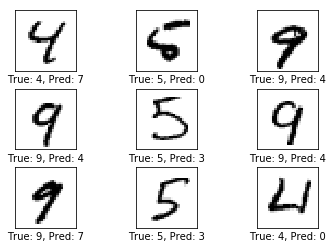

In [49]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations
After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [90]:
optimize(num_iterations=900) # We performed 100 iterations so far.

Optimization Iteration:    101, Training Accuracy  67.2%
Optimization Iteration:    201, Training Accuracy  92.2%
Optimization Iteration:    301, Training Accuracy  85.9%
Optimization Iteration:    401, Training Accuracy  84.4%
Optimization Iteration:    501, Training Accuracy  90.6%
Optimization Iteration:    601, Training Accuracy  92.2%
Optimization Iteration:    701, Training Accuracy  93.8%
Optimization Iteration:    801, Training Accuracy  95.3%
Optimization Iteration:    901, Training Accuracy  92.2%
Time usage: 0:16:55


Accuracy on Test-Set: 93.6% (9361 / 10000)
Example errors:


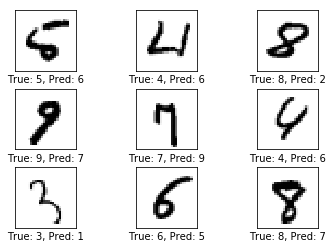

In [91]:
print_test_accuracy(show_example_errors=True)

# Visualization of Weights and Layers
In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

## Helper-function for plotting convolutional weights

In [64]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i < num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]
            
            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
            
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Helper-function for plotting the output of a convolutional layer

In [71]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.
    
    # Create a feed_dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}
    
    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)
    print(values.shape)
    
    # Number of filters used in the conv. Layer.
    num_filters = values.shape[3]
    
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i < num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]
            
            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
            
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Input images
Helper-function for plotting an image.

In [66]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
              interpolation='nearest',
              cmap='binary')
    
    plt.show()

Plot an image from the test-set which will be used as an example below.

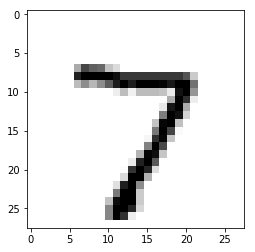

In [67]:
image1 = data.test.images[0]
plot_image(image1)

Plot another example image from the test-set.

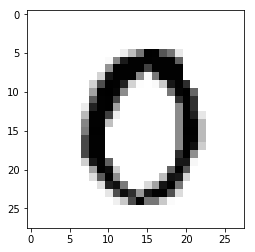

In [68]:
image2 = data.test.images[13]
plot_image(image2)

## Convolutional layer 1
Now plot the filter-weights for the first convolutional layer.
Note that positive weights are red and negative weights are blue.

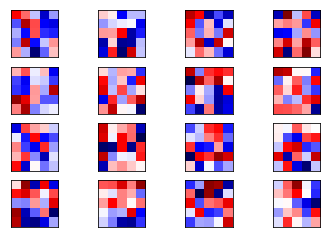

In [69]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14*14 pixels which is half the resolution of the original input image.

(1, 14, 14, 16)


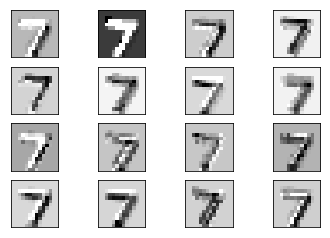

In [72]:
plot_conv_layer(layer=layer_conv1, image=image1)

The following images are the results of applying the convolutional filters to the second image.

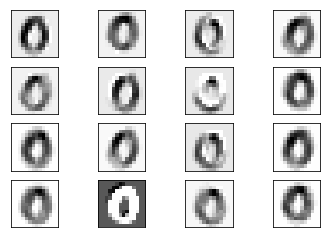

In [99]:
plot_conv_layer(layer_conv1, image=image2)

## Convolutional layer 2
Now plot the filter-weights for the second convolutional layer.  

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weights for the first channel.  

Note again that positive weights are red and negative weights are blue.

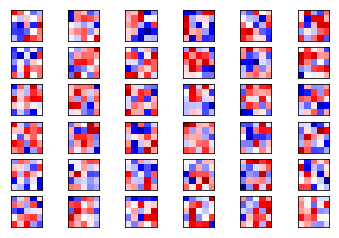

In [100]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

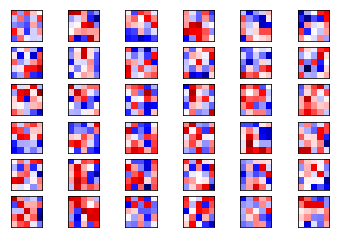

In [101]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

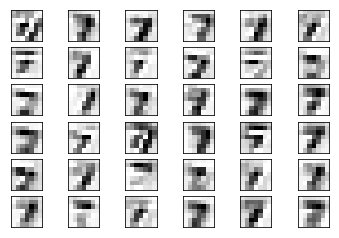

In [103]:
plot_conv_layer(layer=layer_conv2, image=image1)

(1, 7, 7, 36)


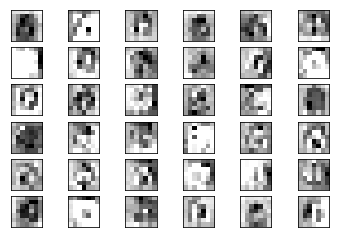

In [73]:
plot_conv_layer(layer=layer_conv2, image=image2)

## Helper-function to show computational graph

In [75]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [76]:
show_graph(tf.get_default_graph().as_graph_def())

In [112]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()
# Return old verbosity value after using.
# tf.logging.set_verbosity(old_v)